In [2]:
import torch
from torch import nn

import torchvision
from torchvision import datasets
from torchvision.transforms import ToTensor

import matplotlib.pyplot as plt

from tqdm.auto import tqdm

print(torch.__version__)

2.3.1+cu121


## Device agnostic code

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

## Load the [`torchvision.datasets.MNIST()`](https://pytorch.org/vision/stable/generated/torchvision.datasets.MNIST.html#torchvision.datasets.MNIST) train and test datasets.

In [4]:
from torchvision.datasets import MNIST

train_dataset = MNIST(root='data',
                      train=True,
                      download=True,
                      transform=ToTensor(),
                      target_transform=None
                      )

test_dataset = MNIST(root='data',
                     train=False,
                      download=True,
                      transform=ToTensor(),
                     )

class_names = train_dataset.classes
len(train_dataset), len(test_dataset), class_names

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:00<00:00, 143531810.33it/s]

Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw



Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 22981539.33it/s]

Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:00<00:00, 54115379.59it/s]


Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 8304502.51it/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



(60000,
 10000,
 ['0 - zero',
  '1 - one',
  '2 - two',
  '3 - three',
  '4 - four',
  '5 - five',
  '6 - six',
  '7 - seven',
  '8 - eight',
  '9 - nine'])

## Visualize at least 5 different samples of the MNIST training dataset.

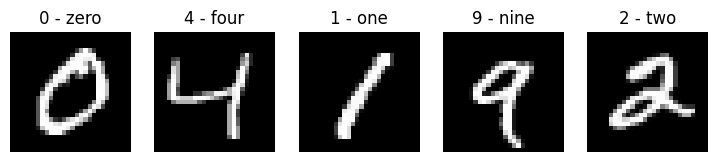

In [5]:
torch.manual_seed(42)
fig = plt.figure(figsize=(9,9))
rows = 1
cols = 5
for i in range(1,6):
  image, label = train_dataset[i]
  fig.add_subplot(rows, cols, i)
  plt.imshow(image.squeeze(), cmap="gray")
  plt.title(class_names[label])
  plt.axis(False);

## 7. Turn the MNIST train and test datasets into dataloaders using `torch.utils.data.DataLoader`, set the `batch_size=32`.

In [6]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(dataset=train_dataset,
                              batch_size=32,
                              shuffle=True
                              )

test_dataloader = DataLoader(dataset=test_dataset,
                             batch_size=32,
                             shuffle=False
                             )

len(train_dataloader),len(test_dataloader)

(1875, 313)

## 8. Recreate `model_2` used in notebook 03 (the same model from the [CNN Explainer website](https://poloclub.github.io/cnn-explainer/), also known as TinyVGG) capable of fitting on the MNIST dataset.

In [7]:
class MNISTmodel(nn.Module):
  def __init__(self,input_shape, hidden_units, output_shape):
    super().__init__()
    self.block1 = nn.Sequential(
        nn.Conv2d(in_channels=input_shape,
                  out_channels=hidden_units,
                  kernel_size=3,
                  padding=1,
                  stride=1),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  padding=1,
                  stride=1),
        nn.ReLU(),
        nn.MaxPool2d(2),
    )
    self.block2 = nn.Sequential(
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  padding=1,
                  stride=1),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  padding=1,
                  stride=1),
        nn.ReLU(),
        nn.MaxPool2d(2),
    )
    self.classifizer = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features=hidden_units*7*7,
                  out_features=output_shape),
    )

  def forward(self, x):
    x = self.block1(x)
    x = self.block2(x)
    x = self.classifizer(x)
    return x

torch.manual_seed(42)
model_0 = MNISTmodel(input_shape=1,
                     hidden_units=10,
                     output_shape=len(class_names)).to(device)

model_0

MNISTmodel(
  (block1): Sequential(
    (0): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifizer): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=490, out_features=10, bias=True)
  )
)

## Loss function and optimizer

In [8]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model_0.parameters(),
                            lr=0.1)

## Train the model you built in exercise 8. for 5 epochs on CPU and GPU and see how long it takes on each.

In [9]:
torch.manual_seed(42)

epochs = 5
model_0.to(device)
for epoch in range(epochs):
  train_loss = 0
  for batch, (X, y) in enumerate(train_dataloader):
        model_0.train()

        X = X.to(device)
        y = y.to(device)

        y_pred = model_0(X)

        loss = loss_fn(y_pred, y)
        train_loss += loss

        optimizer.zero_grad()

        loss.backward()

        optimizer.step()

  train_loss /= len(train_dataloader)

  test_loss_total = 0

  model_0.eval()

  with torch.inference_mode():
    for batch, (X_test, y_test) in enumerate(test_dataloader):
      X_test = X_test.to(device)
      y_test = y_test.to(device)

      test_pred = model_0(X_test)
      test_loss = loss_fn(test_pred,y_test)

      test_loss_total += test_loss

    test_loss_total /= len(test_dataloader)

  print(f"Epoch: {epoch} | Loss: {train_loss:.3f} | Test loss: {test_loss_total:.3f}")


Epoch: 0 | Loss: 0.336 | Test loss: 0.074
Epoch: 1 | Loss: 0.082 | Test loss: 0.066
Epoch: 2 | Loss: 0.064 | Test loss: 0.059
Epoch: 3 | Loss: 0.056 | Test loss: 0.061
Epoch: 4 | Loss: 0.050 | Test loss: 0.047


## Make predictions using your trained model and visualize at least 5 of them comparing the prediciton to the target label.

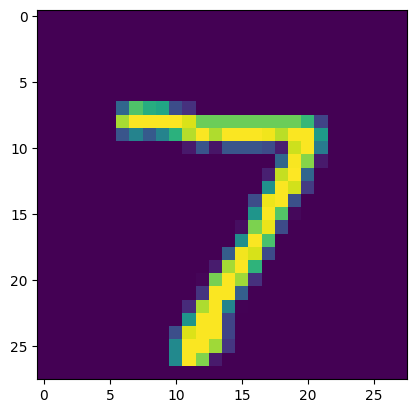

In [13]:
plt.imshow(test_dataset[0][0].squeeze())

In [14]:
model_pred_logits = model_0(test_dataset[0][0].unsqueeze(dim=0).to(device)) # make sure image is right shape + on right device
model_pred_probs = torch.softmax(model_pred_logits, dim=1)
model_pred_label = torch.argmax(model_pred_probs, dim=1)

model_pred_label

tensor([7])

## Plot a confusion matrix comparing your model's predictions to the truth labels.

## Create a random tensor of shape `[1, 3, 64, 64]` and pass it through a `nn.Conv2d()` layer with various hyperparameter settings (these can be any settings you choose), what do you notice if the `kernel_size` parameter goes up and down?

## Use a model similar to the trained `model_2` from notebook 03 to make predictions on the test [`torchvision.datasets.FashionMNIST`](https://pytorch.org/vision/main/generated/torchvision.datasets.FashionMNIST.html) dataset.
* Then plot some predictions where the model was wrong alongside what the label of the image should've been.
* After visualing these predictions do you think it's more of a modelling error or a data error?
* As in, could the model do better or are the labels of the data too close to each other (e.g. a "Shirt" label is too close to "T-shirt/top")?